In [1]:
#!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

import io
import datetime
import collections
import functools
from typing import List, Optional, Tuple
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_ranking as tfr
import tensorflow_federated as tff
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Concatenate,
    Dense,
    Embedding,
    Flatten,
    Input,
    Multiply,
)

2024-02-09 16:49:22.815171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 16:49:22.815452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 16:49:22.892213: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-09 16:49:23.057550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-09 16:49:27.492774: W tensorflow/compiler/tf2

In [2]:
np.random.seed(42)

In [3]:
ratings_df = pd.read_csv('data/Ratings.csv',delimiter=';')
books_df = pd.read_csv('data/Books.csv',delimiter=';')
ratings_df.head(1)

,User-ID,ISBN,Rating
0,276725,034545104X,0


In [4]:
ratings_df.shape

(1149780, 3)

In [5]:
counts = ratings_df['User-ID'].value_counts()
ratings_df = ratings_df[ratings_df['User-ID'].isin(counts[counts>60].index)]
#ratings_df = ratings_df[ratings_df.Rating > 2]

tot_rating_df = ratings_df.groupby(by='ISBN')['Rating'].sum().reset_index().rename(columns={'Rating':'TotRating'})
ratings_df = ratings_df.merge(tot_rating_df)
ratings_df = ratings_df[ratings_df['TotRating']>20] 

In [6]:
ratings_df.drop(columns=['TotRating'])

,User-ID,ISBN,Rating
8,276925,002542730X,10
9,277427,002542730X,10
10,3363,002542730X,0
11,8019,002542730X,9
12,10030,002542730X,7
...,...,...,...
715085,250925,0836213092,10
715086,271284,0836213092,8
719995,243294,0006510183,10
719996,263344,0006510183,8


In [7]:
book_mapping = {
      old_book: new_book for new_book, old_book in enumerate(
          ratings_df.ISBN.unique())
  }
user_mapping = {
    old_user: new_user for new_user, old_user in enumerate(
        ratings_df['User-ID'].unique())
}

ratings_df.ISBN = ratings_df.ISBN.map(book_mapping)
ratings_df['User-ID'] = ratings_df['User-ID'].map(user_mapping)
books_df.ISBN = books_df.ISBN.map(book_mapping)


In [8]:
ratings_df.head(1)

,User-ID,ISBN,Rating,TotRating
8,0,0,10,297


In [9]:
def create_tf_datasets(ratings_df: pd.DataFrame,
                       batch_size: int = 1,
                       max_examples_per_user: Optional[int] = None,
                       max_clients: Optional[int] = None) -> List[tf.data.Dataset]:
  """Creates TF Datasets containing the movies and ratings for all users."""
  num_users = len(set(ratings_df['User-ID']))
  # Optionally limit to `max_clients` to speed up data loading.
  if max_clients is not None:
    num_users = min(num_users, max_clients)

  def rating_batch_map_fn(rating_batch):
    """Maps a rating batch to an OrderedDict with tensor values."""
    # Each example looks like: {x: movie_id, y: rating}.
    # We won't need the UserID since each client will only look at their own
    # data.
    return collections.OrderedDict([
        ("x", tf.cast(rating_batch[:, 1:2], tf.int64)),
        ("y", tf.cast(rating_batch[:, 2:3], tf.float32))
    ])

  tf_datasets = []
  for user_id in range(num_users):
    # Get subset of ratings_df belonging to a particular user.
    user_ratings_df = ratings_df[ratings_df['User-ID'] == user_id]

    tf_dataset = tf.data.Dataset.from_tensor_slices(user_ratings_df)

    # Define preprocessing operations.
    tf_dataset = tf_dataset.take(max_examples_per_user).shuffle(
        buffer_size=max_examples_per_user, seed=42).batch(batch_size).map(
        rating_batch_map_fn,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    tf_datasets.append(tf_dataset)

  return tf_datasets


def split_tf_datasets(
    tf_datasets: List[tf.data.Dataset],
    train_fraction: float = 0.8,
    val_fraction: float = 0.1,
) -> Tuple[List[tf.data.Dataset], List[tf.data.Dataset], List[tf.data.Dataset]]:
  """Splits a list of user TF datasets into train/val/test by user.
  """
  np.random.seed(42)
  np.random.shuffle(tf_datasets)

  train_idx = int(len(tf_datasets) * train_fraction)
  val_idx = int(len(tf_datasets) * (train_fraction + val_fraction))

  # Note that the val and test data contains completely different users, not
  # just unseen ratings from train users.
  return (tf_datasets[:train_idx], tf_datasets[train_idx:val_idx],
          tf_datasets[val_idx:])


In [10]:
# We limit the number of clients to speed up dataset creation. Feel free to pass
# max_clients=None to load all clients' data.
tf_datasets = create_tf_datasets(
    ratings_df=ratings_df,
    batch_size=5,
    max_examples_per_user=300,
    max_clients=2000)

# Split the ratings into training/val/test by client.
tf_train_datasets, tf_val_datasets, tf_test_datasets = split_tf_datasets(
    tf_datasets,
    train_fraction=0.8,
    val_fraction=0.1)


In [11]:
#list(federated_train_data[0].as_numpy_iterator())

In [12]:
n_users, n_books = len(ratings_df['User-ID'].unique()), len(ratings_df['ISBN'].unique())
n_users, n_books

(2868, 13784)

In [13]:
class UserEmbedding(tf.keras.layers.Layer):
  """Keras layer representing an embedding for a single user"""

  def __init__(self, num_latent_factors, **kwargs):
    super().__init__(**kwargs)
    self.num_latent_factors = num_latent_factors

  def build(self, input_shape):
    self.embedding = self.add_weight(
        shape=(1, self.num_latent_factors),
        initializer='uniform',
        dtype=tf.float32,
        name='UserEmbeddingKernel')
    super().build(input_shape)

  def call(self, inputs):
    return self.embedding

  def compute_output_shape(self):
    return (1, self.num_latent_factors)


def get_matrix_factorization_model(
    num_items: int,
    num_latent_factors: int,
    dense_layers: List[int] = [8, 4],
    reg_layers: List[int] = [0.01, 0.01],
    activation_dense: str = "relu") ->  keras.Model:
    global_layers = []
    local_layers = []
    

    # Extract the item embedding.
    item_input = tf.keras.layers.Input(shape=[1], name='Item')
    item_embedding_layer = tf.keras.layers.Embedding(
        num_items,
        num_latent_factors,
        name='ItemEmbedding')
        

    global_layers.append(item_embedding_layer)
    
    flat_item_vec = tf.keras.layers.Flatten(name='FlattenItems')(
        item_embedding_layer(item_input))
    
    # Extract the user embedding.
    user_embedding_layer = UserEmbedding(
        num_latent_factors,
        name='UserEmbedding')
    
    
    local_layers.append(user_embedding_layer)
    
    # The item_input never gets used by the user embedding layer,
    # but this allows the model to directly use the user embedding.
    flat_user_vec = tf.keras.layers.Flatten()(user_embedding_layer(item_input))
    
    pred = tf.keras.layers.Dot(
      1, normalize=False, name='Dot')([flat_user_vec, flat_item_vec])
 
    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 1], dtype=tf.int64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32))

    model = tf.keras.Model(inputs=item_input, outputs=pred)

    return tff.learning.models.ReconstructionModel.from_keras_model_and_layers(
      keras_model=model,
      global_layers=global_layers,
      local_layers=local_layers,
      input_spec=input_spec)






In [14]:
# This will be used to produce our training process.
# User and item embeddings will be 50-dimensional.
import functools 

model_fn = functools.partial(
    get_matrix_factorization_model,
    num_items=n_books,
    num_latent_factors=50)


In [15]:
class RatingAccuracy(tf.keras.metrics.Mean):


  def __init__(self,
               name: str = 'rating_accuracy',
               **kwargs):
    super().__init__(name=name, **kwargs)

  def update_state(self,
                   y_true: tf.Tensor,
                   y_pred: tf.Tensor,
                   sample_weight: Optional[tf.Tensor] = None):
    absolute_diffs = tf.abs(y_true - y_pred)
    # A [batch_size, 1] tf.bool tensor indicating correctness within the
    # threshold for each example in a batch. A 0.5 threshold corresponds
    # to correctness when predictions are rounded to the nearest whole
    # number.
    example_accuracies = tf.less_equal(absolute_diffs, 0.5)
    super().update_state(example_accuracies, sample_weight=sample_weight)


loss_fn = lambda: tf.keras.losses.MeanSquaredError()
#metrics_fn = lambda: [RatingAccuracy()]

metrics_fn = lambda: [RatingAccuracy(),tfr.keras.metrics.NDCGMetric(name='ndcg_10',topn=10),tfr.keras.metrics.HitsMetric(name='hr_10', topn=10) ]


In [16]:
#metrics_fn = lambda: [RatingAccuracy()]

# We'll use this by doing:
# state = training_process.initialize()
# state, metrics = training_process.next(state, federated_train_data)
training_process = tff.learning.algorithms.build_fed_recon(
    model_fn=model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.5),
    reconstruction_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.1))



In [17]:
evaluation_process = tff.learning.algorithms.build_fed_recon_eval(
    model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    reconstruction_optimizer_fn=functools.partial(
            tf.keras.optimizers.SGD, 0.1))


In [18]:
state = training_process.initialize()
model = training_process.get_model_weights(state)
print(model)
print('Item variables shape:', model.trainable[0].shape)


2024-02-09 16:52:21.367289: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-09 16:52:21.367688: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-09 16:52:21.423692: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-09 16:52:21.423946: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-09 16:52:23.631112: E external/org_tensorflow/tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute debug_name which is not in the op definition: Op<name=VarHandleOp; signature= -> resource:resource; attr=container:string,default=""; attr=shared_name:string,default=""; attr=dtype:type; attr=shape:shape; attr=allowed_devices:list(string),default=[]; is_stateful=true> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes wi

ModelWeights(trainable=[array([[-0.03178819,  0.02917478,  0.01359543, ...,  0.00345729,
         0.00098564, -0.0097919 ],
       [ 0.02994862, -0.03001793, -0.02730309, ...,  0.03650763,
        -0.01828467, -0.03298517],
       [ 0.02975413, -0.00812041,  0.02573751, ...,  0.04716365,
        -0.03469024,  0.04589799],
       ...,
       [-0.02252973, -0.00997091, -0.01616838, ..., -0.00419636,
         0.01708497, -0.0010734 ],
       [ 0.01075046, -0.01353018, -0.02363389, ...,  0.01801014,
         0.04018028,  0.04380692],
       [ 0.0247546 ,  0.0358024 , -0.00807155, ...,  0.04055793,
        -0.03722791, -0.00434743]], dtype=float32)], non_trainable=[])
Item variables shape: (13784, 50)


In [19]:

eval_state = evaluation_process.initialize()
eval_state = evaluation_process.set_model_weights(
  eval_state, training_process.get_model_weights(state)
)
_, eval_metrics = evaluation_process.next(eval_state, tf_val_datasets)
print('Initial Eval:', eval_metrics['client_work']['eval'])


2024-02-09 16:52:25.439974: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-09 16:52:25.440256: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-09 16:52:25.479048: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-09 16:52:25.479361: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-09 16:52:25.770316: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-09 16:52:25.770598: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-09 16:52:27.094486: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-09 16:52:27.094724: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


Initial Eval: OrderedDict([('current_round_metrics', OrderedDict([('rating_accuracy', 0.6645147), ('ndcg_10', 0.3354853), ('hr_10', 0.3354853), ('loss', 21.886587)])), ('total_rounds_metrics', OrderedDict([('rating_accuracy', 0.6645147), ('ndcg_10', 0.3354853), ('hr_10', 0.3354853), ('loss', 21.886587)]))])


2024-02-09 16:52:44.346303: E external/org_tensorflow/tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute debug_name which is not in the op definition: Op<name=VarHandleOp; signature= -> resource:resource; attr=container:string,default=""; attr=shared_name:string,default=""; attr=dtype:type; attr=shape:shape; attr=allowed_devices:list(string),default=[]; is_stateful=true> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node total_3}}


In [20]:
NUM_ROUNDS = 25

train_losses = []
train_accs = []

state = training_process.initialize()

for i in range(NUM_ROUNDS):
  federated_train_data = np.random.choice(tf_train_datasets, size=3).tolist()
  state, metrics = training_process.next(state, federated_train_data)
  print(f'Train round {i}:', metrics['client_work']['train'])
  train_losses.append(metrics['client_work']['train']['loss'])
  train_accs.append(metrics['client_work']['train']['ndcg_10'])


eval_state = evaluation_process.set_model_weights(
  eval_state, training_process.get_model_weights(state))
_, eval_metrics = evaluation_process.next(eval_state, tf_val_datasets)
print('Final Eval:', eval_metrics['client_work']['eval'])


2024-02-09 16:52:54.512376: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-09 16:52:54.512660: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-09 16:52:55.053237: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-09 16:52:55.053508: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-09 16:52:55.082962: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-09 16:52:55.083158: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-09 16:52:55.119042: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-09 16:52:55.119275: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


Train round 0: OrderedDict([('rating_accuracy', 0.76), ('ndcg_10', 0.24), ('hr_10', 0.24), ('loss', 13.80206)])
Train round 1: OrderedDict([('rating_accuracy', 0.6181818), ('ndcg_10', 0.38181818), ('hr_10', 0.38181818), ('loss', 25.123684)])
Train round 2: OrderedDict([('rating_accuracy', 0.56565654), ('ndcg_10', 0.43434343), ('hr_10', 0.43434343), ('loss', 26.739109)])
Train round 3: OrderedDict([('rating_accuracy', 0.49377593), ('ndcg_10', 0.5062241), ('hr_10', 0.5062241), ('loss', 23.48204)])
Train round 4: OrderedDict([('rating_accuracy', 0.519084), ('ndcg_10', 0.48091602), ('hr_10', 0.48091602), ('loss', 35.76567)])
Train round 5: OrderedDict([('rating_accuracy', 0.75330395), ('ndcg_10', 0.24669604), ('hr_10', 0.24669604), ('loss', 17.401373)])
Train round 6: OrderedDict([('rating_accuracy', 0.44954127), ('ndcg_10', 0.5504587), ('hr_10', 0.5504587), ('loss', 43.36043)])
Train round 7: OrderedDict([('rating_accuracy', 0.76111114), ('ndcg_10', 0.23888889), ('hr_10', 0.23888889), ('l

In [21]:
eval_state = evaluation_process.set_model_weights(
    eval_state, training_process.get_model_weights(state)
)
_, eval_metrics = evaluation_process.next(eval_state, tf_test_datasets)
print('Final Test:', eval_metrics['client_work']['eval'])


Final Test: OrderedDict([('current_round_metrics', OrderedDict([('rating_accuracy', 0.6326312), ('ndcg_10', 0.319095), ('hr_10', 0.319095), ('loss', 20.56019)])), ('total_rounds_metrics', OrderedDict([('rating_accuracy', 0.6326312), ('ndcg_10', 0.319095), ('hr_10', 0.319095), ('loss', 20.56019)]))])


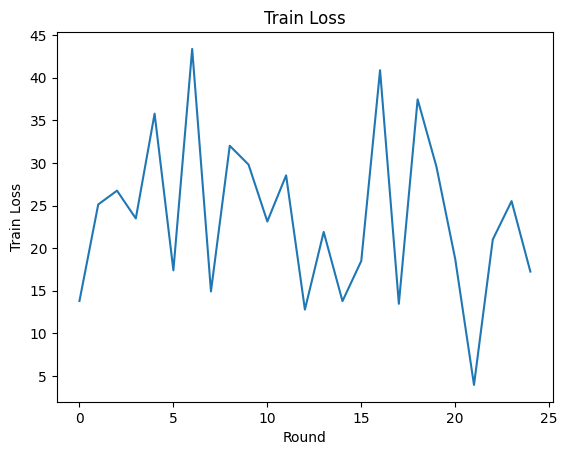

In [22]:
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel('Train Loss')
plt.xlabel('Round')
plt.title('Train Loss')
plt.show()

